# Мониторинг экосистемы: Температура

In [2]:
!pip install -r requirements.txt

  Using cached openmeteo_requests-1.7.5-py3-none-any.whl.metadata (11 kB)
  Using cached requests_cache-1.3.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached retry_requests-2.0.0-py3-none-any.whl.metadata (2.6 kB)
     ---------------------------------------- 0.0/52.8 kB ? eta -:--:--
     ------- -------------------------------- 10.2/52.8 kB ? eta -:--:--
     -------------------------------------- 52.8/52.8 kB 676.1 kB/s eta 0:00:00
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-5.1.0-py3-none-any.whl.metadata (31 kB)
  Using cached niquests-3.17.0-py3-none-any.whl.metadata (17 kB)
  Using cached openmeteo_sdk-1.25.0-py3-none-any.whl.metadata (935 bytes)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached cattrs-25.3.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached url_normalize-2.2.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached urllib3-


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta

# 1. Настраиваем клиент с кэшированием и повторами при ошибках
# Это ускорит повторные запуски и сделает код надежнее [citation:3][citation:7]
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)  # Кэш на 1 час
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# 2. Параметры запроса
# Координаты Москвы
LATITUDE = 55.75
LONGITUDE = 37.62

# Рассчитываем даты: последние 40 дней
end_date = datetime.now()
start_date = end_date - timedelta(days=40)

# Форматируем даты
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print(f"🌍 Москва ({LATITUDE}, {LONGITUDE})")
print(f"📅 Период: с {start_str} по {end_str}")

# 3. Формируем запрос к историческому API
url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "start_date": start_str,
    "end_date": end_str,
    "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "wind_speed_10m"],
    "timezone": "Europe/Moscow"
}

# 4. Получаем данные
print("⏳ Скачиваем данные...")
responses = openmeteo.weather_api(url, params=params)
response = responses[0]  # Берем первую локацию (Москву)

# 5. Обрабатываем почасовые данные
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()

# 6. Создаем временные метки [citation:2][citation:10]
hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ).tz_convert("Europe/Moscow")  # Конвертируем в московское время
}
hourly_data["temperature"] = hourly_temperature_2m
hourly_data["humidity"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed"] = hourly_wind_speed_10m

# 7. Создаем DataFrame
df = pd.DataFrame(data=hourly_data)

print(f"✅ Успешно! Получено {len(df)} записей")
print("\n📊 Статистика:")
print(f"   Средняя температура: {df['temperature'].mean():.1f}°C")
print(f"   Мин температура: {df['temperature'].min():.1f}°C")
print(f"   Макс температура: {df['temperature'].max():.1f}°C")
print(f"   Всего осадков: {df['precipitation'].sum():.1f} мм")

print("\n👀 Первые несколько строк:")
print(df.head(10).to_string())

# 8. Сохраняем в CSV для дальнейшего использования
df.to_csv('moscow_weather_40days_detailed.csv', index=False)
print("\n💾 Данные сохранены в 'moscow_weather_40days_detailed.csv'")


🌍 Москва (55.75, 37.62)
📅 Период: с 2026-01-07 по 2026-02-16
⏳ Скачиваем данные...
✅ Успешно! Получено 984 записей

📊 Статистика:
   Средняя температура: -10.9°C
   Мин температура: -25.5°C
   Макс температура: 1.6°C
   Всего осадков: 94.3 мм

👀 Первые несколько строк:
                       date  temperature   humidity  precipitation  wind_speed
0 2026-01-07 00:00:00+03:00        -7.00  88.350891            0.1   14.019216
1 2026-01-07 01:00:00+03:00        -6.90  88.016754            0.1   14.019216
2 2026-01-07 02:00:00+03:00        -6.85  88.364845            0.2   15.379206
3 2026-01-07 03:00:00+03:00        -6.70  88.722862            0.2   15.034041
4 2026-01-07 04:00:00+03:00        -6.55  88.392654            0.3   15.443328
5 2026-01-07 05:00:00+03:00        -6.45  87.718513            0.3   13.854155
6 2026-01-07 06:00:00+03:00        -6.50  88.054871            0.1   14.306320
7 2026-01-07 07:00:00+03:00        -6.45  88.059608            0.1   13.141232
8 2026-01-07 08:00:

c:\Users\maksi\OneDrive\Рабочий стол\ab_course\проектная_практика\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загружено 984 часов данных
Период: с 2026-01-07 00:00:00+03:00 по 2026-02-16 23:00:00+03:00


Loading weights: 100%|██████████| 813/813 [00:02<00:00, 375.69it/s, Materializing param=horizon_ff_layer.residual_layer.weight]    
c:\Users\maksi\OneDrive\Рабочий стол\ab_course\проектная_практика\.env\Lib\site-packages\transformers\models\timesfm\modeling_timesfm.py:642: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(freq[: len(inputs)], dtype=torch.int32).reshape(-1, 1),


⏳ Выполняем прогноз...
✅ Прогноз получен на 128 часов


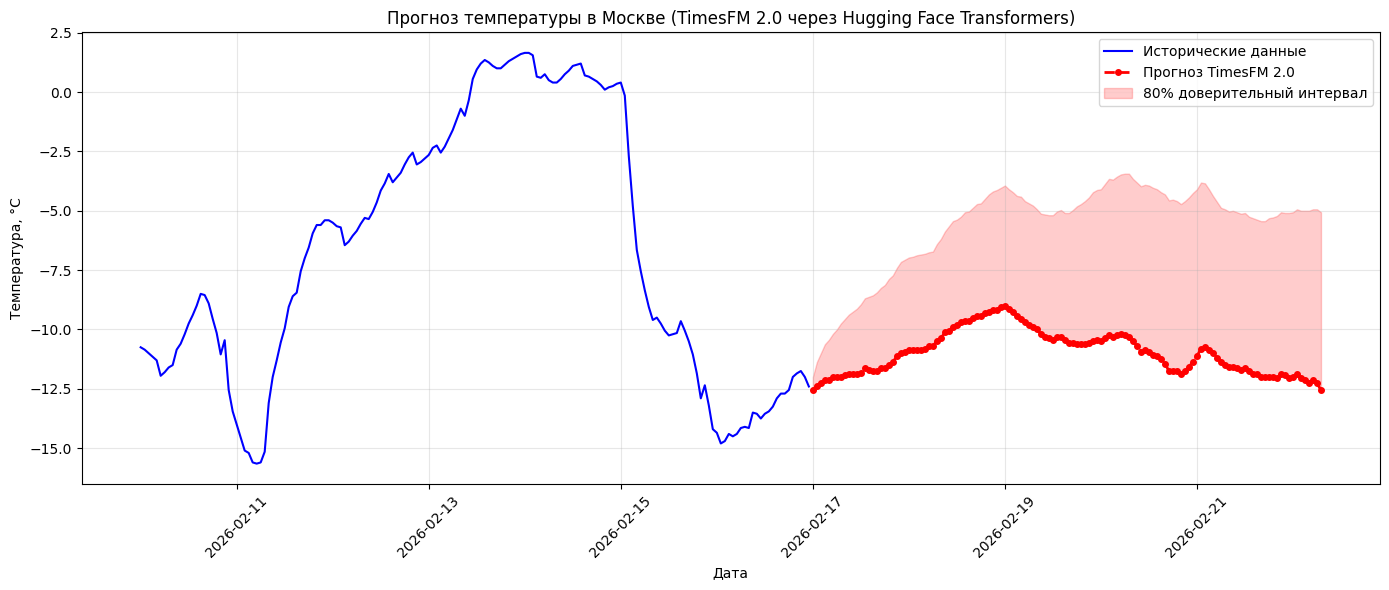


💾 Прогноз сохранён в 'weather_forecast_transformers.csv'


In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import TimesFmModelForPrediction

# Считываем 
df = pd.read_csv('moscow_weather_40days_detailed.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()
your_data = df['temperature'].values.astype(np.float64)

print(f"Загружено {len(your_data)} часов данных")
print(f"Период: с {df.index[0]} по {df.index[-1]}")

# 2. Загружаем модель timesfm-2.0-500m-pytorch
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",  # масштабируемое точечное внимание
    device_map="auto"
)

# --- 3. Подготовка входных данных ---
# Модель ожидает список временных рядов (даже если у нас один ряд)
# Берём последние 512 часов (ограничение модели 2.0) [citation:4]
context_len = 512
if len(your_data) > context_len:
    context_data = your_data[-context_len:]
else:
    context_data = your_data
    print(f"Внимание: данных меньше {context_len} часов")

# Формируем входные данные как список тензоров
forecast_input = [torch.tensor(context_data, dtype=torch.bfloat16)]

# Частота: для почасовых данных обычно 1 (средняя частота)
# 0 - высокая (минуты/секунды), 1 - средняя (часы/дни), 2 - низкая (недели/месяцы) [citation:1]
frequency_input = torch.tensor([1], dtype=torch.long)

# 4. Выполняем прогноз
print("⏳ Выполняем прогноз...")
with torch.no_grad():
    outputs = model(
        past_values=forecast_input,
        freq=frequency_input,
        return_dict=True
    )

# Извлекаем прогноз (mean_predictions - средние значения, full_predictions - с квантилями)
forecast = outputs.mean_predictions.float().cpu().numpy()[0]  # прогноз на 24 часа
quantiles = outputs.full_predictions.float().cpu().numpy()[0]  # все квантили

print(f"✅ Прогноз получен на {len(forecast)} часов")

# 5. Визуализация
plt.figure(figsize=(14, 6))

# Последние 7 дней истории (168 часов)
plt.plot(df.index[-168:], df['temperature'].iloc[-168:], 
         'b-', linewidth=1.5, label='Исторические данные')

# Прогноз на 24 часа
last_date = df.index[-1]
forecast_dates = pd.date_range(
    start=last_date + pd.Timedelta(hours=1), 
    periods=len(forecast), 
    freq='h'
)
plt.plot(forecast_dates, forecast, 'r--', linewidth=2, 
         marker='o', markersize=4, label='Прогноз TimesFM 2.0')

# Добавим доверительный интервал (10% и 90% квантили) [citation:2]
if quantiles.shape[1] >= 9:  # если есть все 9 квантилей
    lower = quantiles[:, 0]  # 10% квантиль
    upper = quantiles[:, -1]  # 90% квантиль
    plt.fill_between(forecast_dates, lower, upper, 
                     color='red', alpha=0.2, label='80% доверительный интервал')

plt.title('Прогноз температуры в Москве (TimesFM 2.0 через Hugging Face Transformers)')
plt.xlabel('Дата')
plt.ylabel('Температура, °C')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохраняем прогноз
forecast_df = pd.DataFrame({
    'datetime': forecast_dates,
    'temperature_forecast': forecast,
    'lower_bound': quantiles[:, 0] if quantiles.shape[1] >= 9 else None,
    'upper_bound': quantiles[:, -1] if quantiles.shape[1] >= 9 else None
})
forecast_df.to_csv('weather_forecast_transformers.csv', index=False)
print("\n💾 Прогноз сохранён в 'weather_forecast_transformers.csv'")
